## Drug trial evaluation

To illustrate Bayesian estimation approach works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a *smart drug* that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those receiving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns

sns.set(color_codes = True)

In [2]:
# data:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

In [3]:
y1 = np.array(drug)
y2 = np.array(placebo)

y = pd.DataFrame(dict(value=np.r_[y1, y2], 
                      group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f79c21f65c0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f79c2190128>], dtype=object)

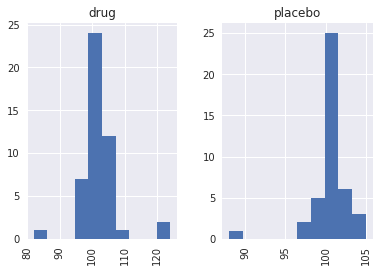

In [4]:
y.hist('value', by='group')

The first step in a Bayesian approach to inference is to specify the full probability model that corresponds to the problem. For this example, Kruschke chooses a Student-t distribution to describe the distributions of the scores in each group. This choice adds robustness to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. The three-parameter Student-t distribution allows for the specification of a mean μ, a precision (inverse-variance) λ and a degrees-of-freedom parameter $\nu$:

Thus, the likelihood functions of our model are specified as follows:
$$y^{(treat)}_i \sim T(\nu, \mu_1, \sigma_1)$$
$$y^{(placebo)}_i \sim T(\nu, \mu_2, \sigma_2)$$

In [5]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

In [6]:
with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)

In [7]:
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

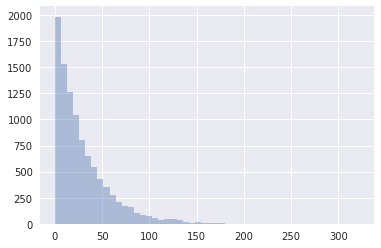

In [8]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

sns.distplot(np.random.exponential(30, size=10000), kde=False);

In [9]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [10]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [11]:
with model:
    trace = pm.sample(20000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -230.24: 100%|██████████| 200000/200000 [00:30<00:00, 6460.13it/s]
Finished [100%]: Average ELBO = -230.24
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 20000/20000 [00:39<00:00, 501.66it/s]


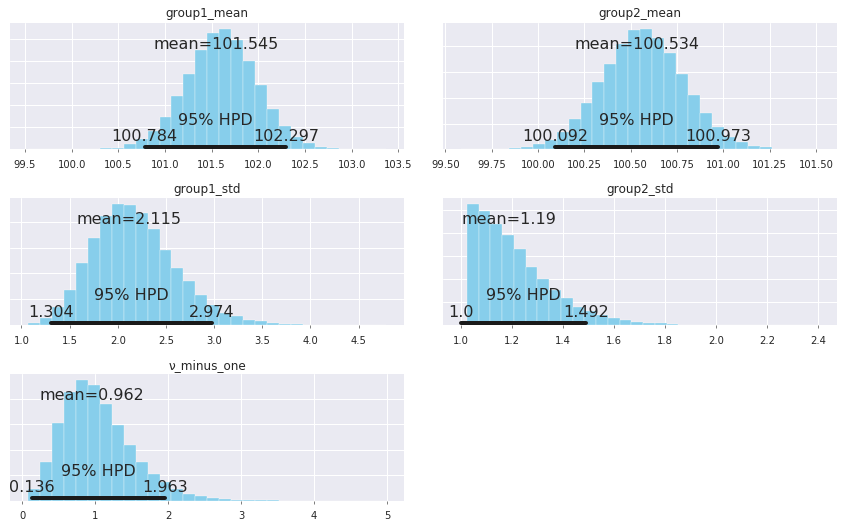

In [12]:
pm.plot_posterior(trace, varnames=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

In [13]:
import theano

theano.__version__

'1.0.1'

In [14]:
!pip install --upgrade theano

Requirement already up-to-date: theano in /home/s4szqx/anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: scipy>=0.14 in /home/s4szqx/anaconda3/lib/python3.6/site-packages (from theano)
Requirement already up-to-date: numpy>=1.9.1 in /home/s4szqx/anaconda3/lib/python3.6/site-packages (from theano)
Requirement already up-to-date: six>=1.9.0 in /home/s4szqx/anaconda3/lib/python3.6/site-packages (from theano)
